<a href="https://www.kaggle.com/code/kmljts/binary-pneumonia-detection?scriptVersionId=179431836" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# import os
# for root, folders, filenames in os.walk('/kaggle/input'):
#    print(root, folders)

In [2]:
!nvidia-smi

Thu May 23 21:29:06 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla P100-PCIE-16GB           Off | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0              26W / 250W |      0MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split

from torchvision import datasets, transforms, models
from torchmetrics import ConfusionMatrix, AUROC
from mlxtend.plotting import plot_confusion_matrix

import os
from datetime import datetime, timedelta

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import pandas as pd
import random

from tqdm.auto import tqdm

In [4]:
input_dir = '/kaggle/input'
dataset_path = os.path.join(input_dir, 'chest-xray-pneumonia/chest_xray/chest_xray')
train_dataset_path = os.path.join(dataset_path, 'train')
val_dataset_path = os.path.join(dataset_path, 'val')
test_dataset_path = os.path.join(dataset_path, 'test')

output_dir = '/kaggle/working'
model_save_path = os.path.join(output_dir, 'models')
result_save_path = os.path.join(output_dir, 'results')
plot_save_path = os.path.join(output_dir, 'plots')

os.makedirs(model_save_path, exist_ok=True)
os.makedirs(result_save_path, exist_ok=True)
os.makedirs(plot_save_path, exist_ok=True)

train_dataset_path, val_dataset_path, test_dataset_path, model_save_path, result_save_path, plot_save_path

('/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train',
 '/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val',
 '/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/test',
 '/kaggle/working/models',
 '/kaggle/working/results',
 '/kaggle/working/plots')

In [5]:
# import shutil
# shutil.rmtree(output_dir)

In [6]:
# sorted(os.listdir(model_save_path)), sorted(os.listdir(result_save_path)), sorted(os.listdir(plot_save_path))

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

device

device(type='cuda')

In [8]:
torch.cuda.empty_cache()

In [9]:
# BATCH_SIZE = 4
# LR = 1e-6
BATCH_SIZE = 32
LR = 1e-7
EPOCHS = 50

USE_BEST_MODEL_YET = False
NORMALIZE = False
# NORMALIZE = True

In [10]:
torch.cuda.empty_cache()

In [11]:
def current_datetime():
    cur_datetime = datetime.now() + timedelta(hours=5, minutes=30) # IST
    return cur_datetime.strftime("%Y-%m-%d_%H-%M-%S")

def unique_file_namer(model_name, n_epochs=EPOCHS, learning_rate=LR, batch_size=BATCH_SIZE):
    return f'{current_datetime()}_{model_name}_{n_epochs}_{learning_rate:.2e}_{batch_size}'

In [12]:
class UnNormalize:
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        return tensor.clamp(-1, 1) * self.std + self.mean
    
class Identity:
    def __call__(self, tensor):
        return tensor

img_to_tensor = transforms.Compose([
    transforms.Resize((448,) * 2),
#     transforms.RandomRotation(30),
#     transforms.RandomResizedCrop((128,) * 2),
#     transforms.RandomHorizontalFlip(),
#     transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
#     transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=0.0),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5]) if NORMALIZE else Identity()
])

tensor_to_img = transforms.Compose([
    UnNormalize(0.5, 0.5) if NORMALIZE else Identity(),
    transforms.ToPILImage()
])

In [13]:
def random_sample(dataset, classes):
    input, target = random.choice(dataset)

    image = tensor_to_img(input)
    display(image)
    print('Target:', classes[target])

def random_pred(dataset, model, classes):
    input, target = random.choice(dataset)

    input = input.to(device)
    image = tensor_to_img(input)
    display(image)

    model.eval()
    with torch.inference_mode():
        logits = model(input.unsqueeze(0))

    print(f'{"Raw Logits: ":30}{logits}') # raw logits
    probs = logits.softmax(1)
    print(f'{"Prediction Probabilities: ":30}{probs}') # prediction probabilities
    label = probs.argmax(1).item()
    print(f'{"Prediction Labels: ":30}{label}', end='\n\n') # prediction label
    
    print('Prediction:', classes[label])
    print('Target:', classes[target])

def dataset_analyzer(dataset, classes):
    freqs = [0] * len(classes)
    for X, y in dataset:
        freqs[y] += 1

    return {classes[i]: freqs[i] for i in range(len(classes))}

In [14]:
def harmonic_mean(a, b):
    if a + b == 0: return 0
    return 2 * a * b / (a + b)

def manage_nan(tensor):
    return tensor if not torch.isnan(tensor).item() else torch.tensor(0.0).to(device)

def confmat_to_accuracy(confmat): # micro
    num_classes = confmat.shape[0]

    correct_preds = 0
    for i in range(num_classes):
        correct_preds += confmat[i, i]
    all_preds = confmat.sum()

    acc = manage_nan(correct_preds / all_preds)

    return acc.item()

def confmat_to_precision(confmat): # macro
    num_classes = confmat.shape[0]

    if num_classes == 2:
        return manage_nan(confmat[1, 1] / confmat[:, 1].sum()).item()

    prec = 0
    for i in range(num_classes):
        prec += manage_nan(confmat[i, i] / confmat[:, i].sum())
    prec /= num_classes

    return prec.item()

def confmat_to_recall(confmat): # macro
    num_classes = confmat.shape[0]

    if num_classes == 2:
        return manage_nan(confmat[1, 1] / confmat[1].sum()).item()

    rec = 0
    for i in range(num_classes):
        rec += manage_nan(confmat[i, i] / confmat[i].sum())
    rec /= num_classes

    return rec.item()

def confmat_to_f1score(confmat): # macro
    num_classes = confmat.shape[0]

    if num_classes == 2:
        return harmonic_mean(confmat_to_precision(confmat), confmat_to_recall(confmat))

    f1 = 0
    for i in range(num_classes):
        prec = manage_nan(confmat[i, i] / confmat[:, i].sum())
        rec = manage_nan(confmat[i, i] / confmat[i].sum())

        f1 += harmonic_mean(prec, rec)
    f1 /= num_classes

    return f1.item()

In [15]:
train_dataset = datasets.ImageFolder(train_dataset_path, transform=img_to_tensor)

len(train_dataset), random.choice(train_dataset), train_dataset.classes

(5216,
 (tensor([[[0.0392, 0.0353, 0.0392,  ..., 0.0902, 0.0902, 0.0824],
           [0.0392, 0.0353, 0.0392,  ..., 0.0902, 0.0863, 0.0824],
           [0.0392, 0.0353, 0.0392,  ..., 0.0902, 0.0863, 0.0784],
           ...,
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
  
          [[0.0392, 0.0353, 0.0392,  ..., 0.0902, 0.0902, 0.0824],
           [0.0392, 0.0353, 0.0392,  ..., 0.0902, 0.0863, 0.0824],
           [0.0392, 0.0353, 0.0392,  ..., 0.0902, 0.0863, 0.0784],
           ...,
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
  
          [[0.0392, 0.0353, 0.0392,  ..., 0.0902, 0.0902, 0.0824],
           [0.0392, 0.0353, 0.0392,  ..., 0.0902, 0.0863, 0.0824],
           [0.0

In [16]:
val_dataset = datasets.ImageFolder(val_dataset_path, transform=img_to_tensor)

len(val_dataset), random.choice(val_dataset), val_dataset.classes

(16,
 (tensor([[[0.0078, 0.0078, 0.0078,  ..., 0.0431, 0.0353, 0.0196],
           [0.0078, 0.0078, 0.0078,  ..., 0.0431, 0.0353, 0.0196],
           [0.0078, 0.0078, 0.0078,  ..., 0.0392, 0.0275, 0.0157],
           ...,
           [0.0275, 0.0275, 0.0275,  ..., 0.0314, 0.0314, 0.0314],
           [0.0275, 0.0275, 0.0275,  ..., 0.0314, 0.0314, 0.0314],
           [0.0275, 0.0275, 0.0275,  ..., 0.0314, 0.0314, 0.0314]],
  
          [[0.0078, 0.0078, 0.0078,  ..., 0.0431, 0.0353, 0.0196],
           [0.0078, 0.0078, 0.0078,  ..., 0.0431, 0.0353, 0.0196],
           [0.0078, 0.0078, 0.0078,  ..., 0.0392, 0.0275, 0.0157],
           ...,
           [0.0275, 0.0275, 0.0275,  ..., 0.0314, 0.0314, 0.0314],
           [0.0275, 0.0275, 0.0275,  ..., 0.0314, 0.0314, 0.0314],
           [0.0275, 0.0275, 0.0275,  ..., 0.0314, 0.0314, 0.0314]],
  
          [[0.0078, 0.0078, 0.0078,  ..., 0.0431, 0.0353, 0.0196],
           [0.0078, 0.0078, 0.0078,  ..., 0.0431, 0.0353, 0.0196],
           [0.007

In [17]:
test_dataset = datasets.ImageFolder(test_dataset_path, transform=img_to_tensor)

len(test_dataset), random.choice(test_dataset), test_dataset.classes

(624,
 (tensor([[[0.1137, 0.1255, 0.1176,  ..., 0.3922, 0.5529, 0.5608],
           [0.1176, 0.1216, 0.1176,  ..., 0.5451, 0.5922, 0.5765],
           [0.1176, 0.1176, 0.1176,  ..., 0.6157, 0.6039, 0.5922],
           ...,
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
  
          [[0.1137, 0.1255, 0.1176,  ..., 0.3922, 0.5529, 0.5608],
           [0.1176, 0.1216, 0.1176,  ..., 0.5451, 0.5922, 0.5765],
           [0.1176, 0.1176, 0.1176,  ..., 0.6157, 0.6039, 0.5922],
           ...,
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
  
          [[0.1137, 0.1255, 0.1176,  ..., 0.3922, 0.5529, 0.5608],
           [0.1176, 0.1216, 0.1176,  ..., 0.5451, 0.5922, 0.5765],
           [0.11

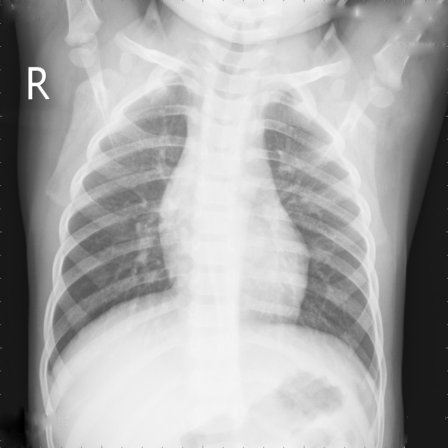

Target: NORMAL


In [18]:
random_sample(train_dataset, classes=train_dataset.classes)

In [19]:
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [20]:
len(train_dataloader), len(val_dataloader), len(test_dataloader)

(163, 1, 20)

In [21]:
# n_samples = torch.zeros(2)

# for X, y in train_dataset:
#     n_samples[y] += 1

n_samples = torch.tensor([1341, 3875]).to(device)

n_samples

tensor([1341, 3875], device='cuda:0')

In [22]:
# class_weights = n_samples.sum() / n_samples
class_weights = torch.tensor([1.0, 0.1]).to(device)

class_weights

tensor([1.0000, 0.1000], device='cuda:0')

In [23]:
class PneumoniaDetector(nn.Module):
    def __init__(self):
        super().__init__()

        self.resnet = models.resnet18(weights='DEFAULT')
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, 2) # in_features = 512

    def forward(self, x):
        return self.resnet(x)

In [24]:
model = PneumoniaDetector().to(device)

if USE_BEST_MODEL_YET:
    best_model_name = sorted(os.listdir(model_save_path))[-1]
    best_model_path = os.path.join(model_save_path, best_model_name)
    print(best_model_path)
    model.load_state_dict(torch.load(best_model_path))

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 124MB/s]


In [25]:
model.eval()
with torch.inference_mode():
    pred = model(random.choice(train_dataset)[0].to(device).unsqueeze(0))
pred

tensor([[0.4101, 0.2977]], device='cuda:0')

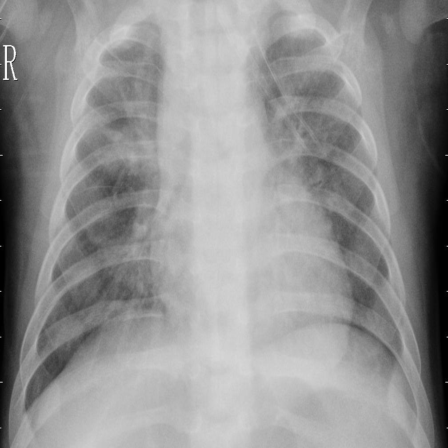

Raw Logits:                   tensor([[0.1122, 0.2469]], device='cuda:0')
Prediction Probabilities:     tensor([[0.4664, 0.5336]], device='cuda:0')
Prediction Labels:            1

Prediction: PNEUMONIA
Target: PNEUMONIA


In [26]:
random_pred(train_dataset, model, classes=train_dataset.classes)

In [27]:
criterion = nn.CrossEntropyLoss(weight=class_weights)
confmat_metric = ConfusionMatrix(task='multiclass', num_classes=2).to(device)
auroc_metric = AUROC(task='multiclass', num_classes=2).to(device)

optimizer = optim.Adam(model.parameters(), lr=LR)

In [28]:
train_losses = []
val_losses = []
accs = []
precs = []
recs = []
f1s = []
aurocs = []

In [29]:
train_losses, val_losses, accs, precs, recs, f1s, aurocs

([], [], [], [], [], [], [])

  0%|          | 0/20 [00:00<?, ?it/s]

Cross Entropy Loss: 0.5400
Accuracy: 40.71% | Precision: 91.67% | Recall: 5.64% | F1 Score: 10.63%
AUROC: 0.7851


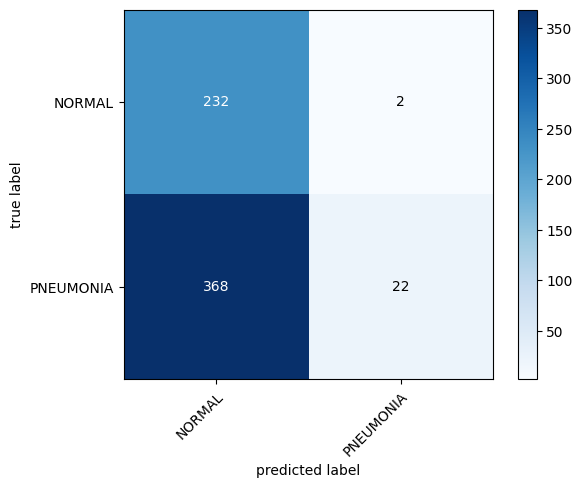

In [30]:
loss = 0
auroc = 0
master_confmat = torch.zeros(2, 2).to(device)

model.eval()
with torch.inference_mode():
    for X, y in tqdm(test_dataloader):
        X, y = X.to(device), y.to(device)
        logits = model(X)
        probs = logits.softmax(1)
        labels = probs.argmax(1)

        loss += criterion(logits, y).item()
        auroc += auroc_metric(probs, y).item()
        master_confmat += confmat_metric(labels, y)

loss /= len(test_dataloader)
auroc /= len(test_dataloader)
acc = confmat_to_accuracy(master_confmat)
prec = confmat_to_precision(master_confmat)
rec = confmat_to_recall(master_confmat)
f1 = confmat_to_f1score(master_confmat)

train_losses.append(loss)
val_losses.append(loss)
accs.append(acc)
precs.append(prec)
recs.append(rec)
f1s.append(f1)
aurocs.append(auroc)

print(f'Cross Entropy Loss: {loss:.4f}')
print(f'Accuracy: {acc * 100:.2f}% | Precision: {prec * 100:.2f}% | Recall: {rec * 100:.2f}% | F1 Score: {f1 * 100:.2f}%')
print(f'AUROC: {auroc:.4f}')

fig, ax = plot_confusion_matrix(
    conf_mat=master_confmat.cpu().numpy(),
    class_names=train_dataset.classes,
    colorbar=True
)

In [31]:
best_acc = acc
best_acc_epoch = 0

In [32]:
prev_size = len(train_losses)

for epoch in tqdm(range(EPOCHS)):
    train_loss = 0
    val_loss = 0
    auroc = 0
    master_confmat = torch.zeros(2, 2).to(device)

    model.train()
    for X, y in tqdm(train_dataloader):
        X, y = X.to(device), y.to(device)
        pred = model(X)
        loss = criterion(pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    model.eval()
    with torch.inference_mode():
        for X, y in tqdm(test_dataloader):
            X, y = X.to(device), y.to(device)
            logits = model(X)
            probs = logits.softmax(1)
            labels = probs.argmax(1)

            val_loss += criterion(logits, y).item()
            auroc += auroc_metric(probs, y).item()
            master_confmat += confmat_metric(labels, y)

    train_loss /= len(train_dataloader)
    val_loss /= len(test_dataloader)
    auroc /= len(test_dataloader)
    acc = confmat_to_accuracy(master_confmat)
    prec = confmat_to_precision(master_confmat)
    rec = confmat_to_recall(master_confmat)
    f1 = confmat_to_f1score(master_confmat)

    print(f'Epoch: {epoch + prev_size}/{EPOCHS + prev_size - 1}')
    print(f'Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}')
    print(f'Accuracy: {acc * 100:.2f}% | Precision: {prec * 100:.2f}% | Recall: {rec * 100:.2f}% | F1 Score: {f1 * 100:.2f}%')
    print(f'AUROC: {auroc:.4f}')

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    accs.append(acc)
    precs.append(prec)
    recs.append(rec)
    f1s.append(f1)
    aurocs.append(auroc)

    if acc > best_acc:
        model_name = f'{unique_file_namer(model.__class__.__name__)}.pth'
        model_path = os.path.join(model_save_path, model_name)
        torch.save(model.state_dict(), model_path)
        print('>>> Model saved!')
        print(model_path)

        best_acc = acc
        best_acc_epoch = epoch + prev_size
    
    # reloading the best model yet every 5 epochs
    if epoch % 5 == 4:
        best_model_name = sorted(os.listdir(model_save_path))[-1]
        best_model_path = os.path.join(model_save_path, best_model_name)
        print('Reloaded:', best_model_path)

        model.load_state_dict(torch.load(best_model_path))

    print('\n' + '=' * 80 + '\n')

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/163 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1/50
Train Loss: 0.4923 | Val Loss: 0.4121
Accuracy: 37.50% | Precision: 0.00% | Recall: 0.00% | F1 Score: 0.00%
AUROC: 0.7378




  0%|          | 0/163 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2/50
Train Loss: 0.4626 | Val Loss: 0.3929
Accuracy: 37.50% | Precision: 0.00% | Recall: 0.00% | F1 Score: 0.00%
AUROC: 0.8051




  0%|          | 0/163 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 3/50
Train Loss: 0.4431 | Val Loss: 0.3751
Accuracy: 38.14% | Precision: 100.00% | Recall: 1.03% | F1 Score: 2.03%
AUROC: 0.8446




  0%|          | 0/163 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 4/50
Train Loss: 0.4205 | Val Loss: 0.3586
Accuracy: 39.42% | Precision: 100.00% | Recall: 3.08% | F1 Score: 5.97%
AUROC: 0.8756




  0%|          | 0/163 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 5/50
Train Loss: 0.3899 | Val Loss: 0.3371
Accuracy: 41.03% | Precision: 100.00% | Recall: 5.64% | F1 Score: 10.68%
AUROC: 0.8925
>>> Model saved!
/kaggle/working/models/2024-05-24_03-13-50_PneumoniaDetector_50_1.00e-07_32.pth
Reloaded: /kaggle/working/models/2024-05-24_03-13-50_PneumoniaDetector_50_1.00e-07_32.pth




  0%|          | 0/163 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 6/50
Train Loss: 0.3713 | Val Loss: 0.3225
Accuracy: 43.75% | Precision: 95.35% | Recall: 10.51% | F1 Score: 18.94%
AUROC: 0.9017
>>> Model saved!
/kaggle/working/models/2024-05-24_03-16-32_PneumoniaDetector_50_1.00e-07_32.pth




  0%|          | 0/163 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 7/50
Train Loss: 0.3617 | Val Loss: 0.3173
Accuracy: 48.08% | Precision: 94.59% | Recall: 17.95% | F1 Score: 30.17%
AUROC: 0.9064
>>> Model saved!
/kaggle/working/models/2024-05-24_03-19-13_PneumoniaDetector_50_1.00e-07_32.pth




  0%|          | 0/163 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 8/50
Train Loss: 0.3397 | Val Loss: 0.3033
Accuracy: 51.76% | Precision: 95.88% | Recall: 23.85% | F1 Score: 38.19%
AUROC: 0.9079
>>> Model saved!
/kaggle/working/models/2024-05-24_03-21-56_PneumoniaDetector_50_1.00e-07_32.pth




  0%|          | 0/163 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 9/50
Train Loss: 0.3281 | Val Loss: 0.2928
Accuracy: 55.61% | Precision: 96.69% | Recall: 30.00% | F1 Score: 45.79%
AUROC: 0.9140
>>> Model saved!
/kaggle/working/models/2024-05-24_03-24-36_PneumoniaDetector_50_1.00e-07_32.pth




  0%|          | 0/163 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 10/50
Train Loss: 0.3201 | Val Loss: 0.2900
Accuracy: 57.05% | Precision: 96.92% | Recall: 32.31% | F1 Score: 48.46%
AUROC: 0.9227
>>> Model saved!
/kaggle/working/models/2024-05-24_03-27-18_PneumoniaDetector_50_1.00e-07_32.pth
Reloaded: /kaggle/working/models/2024-05-24_03-27-18_PneumoniaDetector_50_1.00e-07_32.pth




  0%|          | 0/163 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 11/50
Train Loss: 0.3123 | Val Loss: 0.2769
Accuracy: 61.86% | Precision: 96.91% | Recall: 40.26% | F1 Score: 56.88%
AUROC: 0.9118
>>> Model saved!
/kaggle/working/models/2024-05-24_03-30-00_PneumoniaDetector_50_1.00e-07_32.pth




  0%|          | 0/163 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 12/50
Train Loss: 0.2980 | Val Loss: 0.2868
Accuracy: 68.27% | Precision: 97.52% | Recall: 50.51% | F1 Score: 66.55%
AUROC: 0.9185
>>> Model saved!
/kaggle/working/models/2024-05-24_03-32-41_PneumoniaDetector_50_1.00e-07_32.pth




  0%|          | 0/163 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 13/50
Train Loss: 0.2915 | Val Loss: 0.2640
Accuracy: 68.27% | Precision: 97.52% | Recall: 50.51% | F1 Score: 66.55%
AUROC: 0.9245




  0%|          | 0/163 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 14/50
Train Loss: 0.2789 | Val Loss: 0.2668
Accuracy: 74.04% | Precision: 97.11% | Recall: 60.26% | F1 Score: 74.37%
AUROC: 0.9175
>>> Model saved!
/kaggle/working/models/2024-05-24_03-38-06_PneumoniaDetector_50_1.00e-07_32.pth




  0%|          | 0/163 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 15/50
Train Loss: 0.2698 | Val Loss: 0.2557
Accuracy: 75.48% | Precision: 96.84% | Recall: 62.82% | F1 Score: 76.21%
AUROC: 0.9242
>>> Model saved!
/kaggle/working/models/2024-05-24_03-40-50_PneumoniaDetector_50_1.00e-07_32.pth
Reloaded: /kaggle/working/models/2024-05-24_03-40-50_PneumoniaDetector_50_1.00e-07_32.pth




  0%|          | 0/163 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 16/50
Train Loss: 0.2659 | Val Loss: 0.2624
Accuracy: 78.53% | Precision: 95.71% | Recall: 68.72% | F1 Score: 80.00%
AUROC: 0.9235
>>> Model saved!
/kaggle/working/models/2024-05-24_03-43-33_PneumoniaDetector_50_1.00e-07_32.pth




  0%|          | 0/163 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 17/50
Train Loss: 0.2496 | Val Loss: 0.2618
Accuracy: 79.81% | Precision: 95.83% | Recall: 70.77% | F1 Score: 81.42%
AUROC: 0.9214
>>> Model saved!
/kaggle/working/models/2024-05-24_03-46-16_PneumoniaDetector_50_1.00e-07_32.pth




  0%|          | 0/163 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 18/50
Train Loss: 0.2471 | Val Loss: 0.2460
Accuracy: 81.57% | Precision: 95.38% | Recall: 74.10% | F1 Score: 83.41%
AUROC: 0.9338
>>> Model saved!
/kaggle/working/models/2024-05-24_03-48-58_PneumoniaDetector_50_1.00e-07_32.pth




  0%|          | 0/163 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 19/50
Train Loss: 0.2377 | Val Loss: 0.2411
Accuracy: 81.89% | Precision: 95.41% | Recall: 74.62% | F1 Score: 83.74%
AUROC: 0.9346
>>> Model saved!
/kaggle/working/models/2024-05-24_03-51-40_PneumoniaDetector_50_1.00e-07_32.pth




  0%|          | 0/163 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 20/50
Train Loss: 0.2350 | Val Loss: 0.2431
Accuracy: 82.69% | Precision: 95.19% | Recall: 76.15% | F1 Score: 84.62%
AUROC: 0.9358
>>> Model saved!
/kaggle/working/models/2024-05-24_03-54-23_PneumoniaDetector_50_1.00e-07_32.pth
Reloaded: /kaggle/working/models/2024-05-24_03-54-23_PneumoniaDetector_50_1.00e-07_32.pth




  0%|          | 0/163 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 21/50
Train Loss: 0.2265 | Val Loss: 0.2454
Accuracy: 84.13% | Precision: 94.77% | Recall: 78.97% | F1 Score: 86.15%
AUROC: 0.9356
>>> Model saved!
/kaggle/working/models/2024-05-24_03-57-04_PneumoniaDetector_50_1.00e-07_32.pth




  0%|          | 0/163 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 22/50
Train Loss: 0.2157 | Val Loss: 0.2406
Accuracy: 84.29% | Precision: 94.51% | Recall: 79.49% | F1 Score: 86.35%
AUROC: 0.9263
>>> Model saved!
/kaggle/working/models/2024-05-24_03-59-45_PneumoniaDetector_50_1.00e-07_32.pth




  0%|          | 0/163 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 23/50
Train Loss: 0.2178 | Val Loss: 0.2366
Accuracy: 84.29% | Precision: 94.51% | Recall: 79.49% | F1 Score: 86.35%
AUROC: 0.9349




  0%|          | 0/163 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 24/50
Train Loss: 0.2154 | Val Loss: 0.2387
Accuracy: 84.13% | Precision: 95.05% | Recall: 78.72% | F1 Score: 86.12%
AUROC: 0.9265




  0%|          | 0/163 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 25/50
Train Loss: 0.2098 | Val Loss: 0.2402
Accuracy: 85.26% | Precision: 94.61% | Recall: 81.03% | F1 Score: 87.29%
AUROC: 0.9372
>>> Model saved!
/kaggle/working/models/2024-05-24_04-07-44_PneumoniaDetector_50_1.00e-07_32.pth
Reloaded: /kaggle/working/models/2024-05-24_04-07-44_PneumoniaDetector_50_1.00e-07_32.pth




  0%|          | 0/163 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 26/50
Train Loss: 0.2064 | Val Loss: 0.2399
Accuracy: 85.58% | Precision: 94.38% | Recall: 81.79% | F1 Score: 87.64%
AUROC: 0.9398
>>> Model saved!
/kaggle/working/models/2024-05-24_04-10-22_PneumoniaDetector_50_1.00e-07_32.pth




  0%|          | 0/163 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 27/50
Train Loss: 0.1981 | Val Loss: 0.2359
Accuracy: 85.10% | Precision: 94.59% | Recall: 80.77% | F1 Score: 87.14%
AUROC: 0.9405




  0%|          | 0/163 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 28/50
Train Loss: 0.1933 | Val Loss: 0.2326
Accuracy: 84.94% | Precision: 94.58% | Recall: 80.51% | F1 Score: 86.98%
AUROC: 0.9375




  0%|          | 0/163 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 29/50
Train Loss: 0.1890 | Val Loss: 0.2387
Accuracy: 86.70% | Precision: 94.49% | Recall: 83.59% | F1 Score: 88.71%
AUROC: 0.9398
>>> Model saved!
/kaggle/working/models/2024-05-24_04-18-21_PneumoniaDetector_50_1.00e-07_32.pth




  0%|          | 0/163 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 30/50
Train Loss: 0.1940 | Val Loss: 0.2457
Accuracy: 87.02% | Precision: 94.27% | Recall: 84.36% | F1 Score: 89.04%
AUROC: 0.9373
>>> Model saved!
/kaggle/working/models/2024-05-24_04-21-01_PneumoniaDetector_50_1.00e-07_32.pth
Reloaded: /kaggle/working/models/2024-05-24_04-21-01_PneumoniaDetector_50_1.00e-07_32.pth




  0%|          | 0/163 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 31/50
Train Loss: 0.1847 | Val Loss: 0.2271
Accuracy: 85.90% | Precision: 94.41% | Recall: 82.31% | F1 Score: 87.95%
AUROC: 0.9459




  0%|          | 0/163 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 32/50
Train Loss: 0.1860 | Val Loss: 0.2180
Accuracy: 85.26% | Precision: 94.61% | Recall: 81.03% | F1 Score: 87.29%
AUROC: 0.9436




  0%|          | 0/163 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 33/50
Train Loss: 0.1880 | Val Loss: 0.2227
Accuracy: 86.38% | Precision: 94.46% | Recall: 83.08% | F1 Score: 88.40%
AUROC: 0.9465




  0%|          | 0/163 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 34/50
Train Loss: 0.1750 | Val Loss: 0.2575
Accuracy: 88.14% | Precision: 94.38% | Recall: 86.15% | F1 Score: 90.08%
AUROC: 0.9343
>>> Model saved!
/kaggle/working/models/2024-05-24_04-31-49_PneumoniaDetector_50_1.00e-07_32.pth




  0%|          | 0/163 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 35/50
Train Loss: 0.1762 | Val Loss: 0.2357
Accuracy: 87.50% | Precision: 94.32% | Recall: 85.13% | F1 Score: 89.49%
AUROC: 0.9453
Reloaded: /kaggle/working/models/2024-05-24_04-31-49_PneumoniaDetector_50_1.00e-07_32.pth




  0%|          | 0/163 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 36/50
Train Loss: 0.1691 | Val Loss: 0.2454
Accuracy: 88.30% | Precision: 93.91% | Recall: 86.92% | F1 Score: 90.28%
AUROC: 0.9464
>>> Model saved!
/kaggle/working/models/2024-05-24_04-37-08_PneumoniaDetector_50_1.00e-07_32.pth




  0%|          | 0/163 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 37/50
Train Loss: 0.1686 | Val Loss: 0.2260
Accuracy: 87.18% | Precision: 94.54% | Recall: 84.36% | F1 Score: 89.16%
AUROC: 0.9515




  0%|          | 0/163 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 38/50
Train Loss: 0.1656 | Val Loss: 0.2216
Accuracy: 85.42% | Precision: 94.36% | Recall: 81.54% | F1 Score: 87.48%
AUROC: 0.9473




  0%|          | 0/163 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 39/50
Train Loss: 0.1639 | Val Loss: 0.2401
Accuracy: 88.14% | Precision: 94.38% | Recall: 86.15% | F1 Score: 90.08%
AUROC: 0.9483




  0%|          | 0/163 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 40/50
Train Loss: 0.1634 | Val Loss: 0.2457
Accuracy: 89.10% | Precision: 93.75% | Recall: 88.46% | F1 Score: 91.03%
AUROC: 0.9506
>>> Model saved!
/kaggle/working/models/2024-05-24_04-47-42_PneumoniaDetector_50_1.00e-07_32.pth
Reloaded: /kaggle/working/models/2024-05-24_04-47-42_PneumoniaDetector_50_1.00e-07_32.pth




  0%|          | 0/163 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 41/50
Train Loss: 0.1546 | Val Loss: 0.2423
Accuracy: 88.62% | Precision: 93.70% | Recall: 87.69% | F1 Score: 90.60%
AUROC: 0.9502




  0%|          | 0/163 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 42/50
Train Loss: 0.1502 | Val Loss: 0.2478
Accuracy: 89.26% | Precision: 93.77% | Recall: 88.72% | F1 Score: 91.17%
AUROC: 0.9407
>>> Model saved!
/kaggle/working/models/2024-05-24_04-53-02_PneumoniaDetector_50_1.00e-07_32.pth




  0%|          | 0/163 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 43/50
Train Loss: 0.1556 | Val Loss: 0.2506
Accuracy: 89.90% | Precision: 93.60% | Recall: 90.00% | F1 Score: 91.76%
AUROC: 0.9559
>>> Model saved!
/kaggle/working/models/2024-05-24_04-55-43_PneumoniaDetector_50_1.00e-07_32.pth




  0%|          | 0/163 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 44/50
Train Loss: 0.1487 | Val Loss: 0.2437
Accuracy: 88.94% | Precision: 94.21% | Recall: 87.69% | F1 Score: 90.84%
AUROC: 0.9501




  0%|          | 0/163 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 45/50
Train Loss: 0.1559 | Val Loss: 0.2526
Accuracy: 89.74% | Precision: 93.82% | Recall: 89.49% | F1 Score: 91.60%
AUROC: 0.9519
Reloaded: /kaggle/working/models/2024-05-24_04-55-43_PneumoniaDetector_50_1.00e-07_32.pth




  0%|          | 0/163 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 46/50
Train Loss: 0.1478 | Val Loss: 0.2567
Accuracy: 89.74% | Precision: 93.58% | Recall: 89.74% | F1 Score: 91.62%
AUROC: 0.9568




  0%|          | 0/163 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 47/50
Train Loss: 0.1419 | Val Loss: 0.2506
Accuracy: 89.74% | Precision: 93.82% | Recall: 89.49% | F1 Score: 91.60%
AUROC: 0.9518




  0%|          | 0/163 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 48/50
Train Loss: 0.1473 | Val Loss: 0.2552
Accuracy: 89.74% | Precision: 93.58% | Recall: 89.74% | F1 Score: 91.62%
AUROC: 0.9574




  0%|          | 0/163 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 49/50
Train Loss: 0.1446 | Val Loss: 0.2558
Accuracy: 90.22% | Precision: 93.63% | Recall: 90.51% | F1 Score: 92.05%
AUROC: 0.9516
>>> Model saved!
/kaggle/working/models/2024-05-24_05-11-30_PneumoniaDetector_50_1.00e-07_32.pth




  0%|          | 0/163 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 50/50
Train Loss: 0.1370 | Val Loss: 0.2438
Accuracy: 88.94% | Precision: 93.73% | Recall: 88.21% | F1 Score: 90.89%
AUROC: 0.9474
Reloaded: /kaggle/working/models/2024-05-24_05-11-30_PneumoniaDetector_50_1.00e-07_32.pth




/tmp/ipykernel_25/1575607373.py:7: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2, 1, 1)


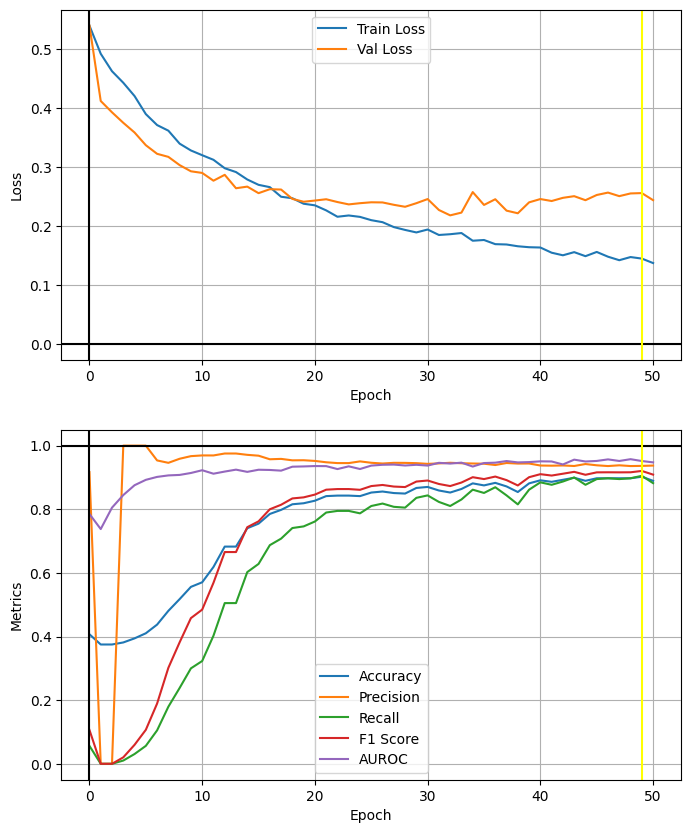

In [33]:
plt.figure(figsize=(8, 10))
plt.title(f'{model.__class__.__name__} Training/Validation Plot')
plt.axis('off')

# ========== (1) ==========

plt.subplot(2, 1, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
if len(train_losses) <= 20:
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.grid(True)
plt.axhline(0, color='black')
plt.axvline(0, color='black')
plt.axvline(best_acc_epoch, color='yellow')
plt.legend(loc='best')
# plt.ylim(-0.05, 1)

# ========== (2) ==========

plt.subplot(2, 1, 2)
plt.plot(accs, label='Accuracy')
plt.plot(precs, label='Precision')
plt.plot(recs, label='Recall')
plt.plot(f1s, label='F1 Score')
plt.plot(aurocs, label='AUROC')
plt.xlabel('Epoch')
plt.ylabel('Metrics')
if len(train_losses) <= 20:
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.grid(True)
plt.axhline(1, color='black')
plt.axvline(0, color='black')
plt.axvline(best_acc_epoch, color='yellow')
plt.legend(loc='best')

plot_file_name = f'{unique_file_namer(model.__class__.__name__)}.png'
plt.savefig(os.path.join(plot_save_path, plot_file_name), bbox_inches='tight')

plt.show()

In [34]:
best_model_name = sorted(os.listdir(model_save_path))[-1]
best_model_path = os.path.join(model_save_path, best_model_name)
print(best_model_path)

model.load_state_dict(torch.load(best_model_path))

/kaggle/working/models/2024-05-24_05-11-30_PneumoniaDetector_50_1.00e-07_32.pth


<All keys matched successfully>

  0%|          | 0/20 [00:00<?, ?it/s]

Cross Entropy Loss: 0.2629 
Accuracy: 90.22% | Precision: 93.63% | Recall: 90.51% | F1 Score: 92.05% 
AUROC: 0.9476


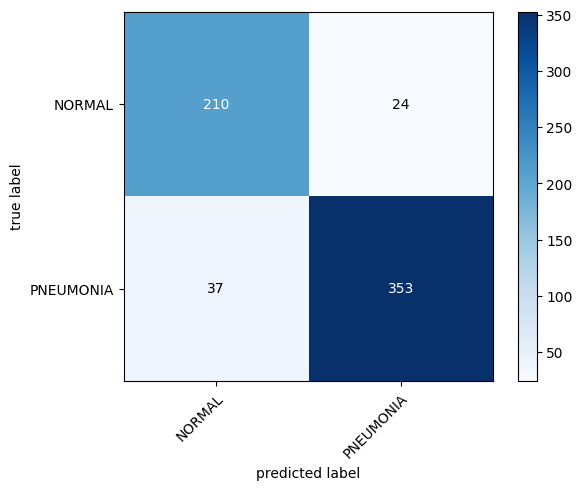

In [35]:
loss = 0
auroc = 0
master_confmat = torch.zeros(2, 2).to(device)

model.eval()
with torch.inference_mode():
    for X, y in tqdm(test_dataloader):
        X, y = X.to(device), y.to(device)
        logits = model(X)
        probs = logits.softmax(1)
        labels = probs.argmax(1)

        loss += criterion(logits, y).item()
        auroc += auroc_metric(probs, y).item()
        master_confmat += confmat_metric(labels, y)

loss /= len(test_dataloader)
auroc /= len(test_dataloader)
acc = confmat_to_accuracy(master_confmat)
prec = confmat_to_precision(master_confmat)
rec = confmat_to_recall(master_confmat)
f1 = confmat_to_f1score(master_confmat)

result = f'Cross Entropy Loss: {loss:.4f} \nAccuracy: {acc * 100:.2f}% | Precision: {prec * 100:.2f}% | Recall: {rec * 100:.2f}% | F1 Score: {f1 * 100:.2f}% \nAUROC: {auroc:.4f}'
print(result)

result_file_name = f'{unique_file_namer(model.__class__.__name__)}.txt'
with open(os.path.join(result_save_path, result_file_name), 'w') as f:
    f.write(result)

fig, ax = plot_confusion_matrix(
    conf_mat=master_confmat.cpu().numpy(),
    class_names=test_dataset.classes,
    colorbar=True
)

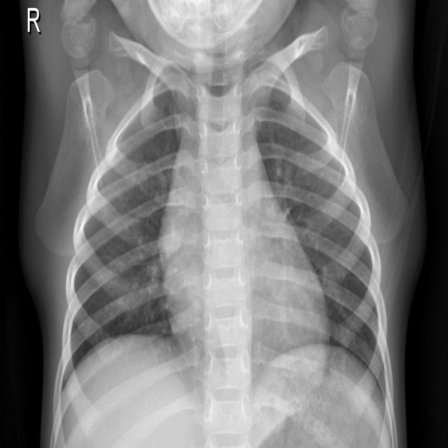

Raw Logits:                   tensor([[ 3.3959, -2.0954]], device='cuda:0')
Prediction Probabilities:     tensor([[0.9959, 0.0041]], device='cuda:0')
Prediction Labels:            0

Prediction: NORMAL
Target: NORMAL


In [36]:
random_pred(test_dataset, model, classes=test_dataset.classes)